# Intro

In this notebook, we will apply the Capital Asset Pricing Model (CAPM) for an individual sotck and a portfolio of stocks. 

In [3]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr

import matplotlib.pyplot as plt
import datetime as dt
import plotly.express as px
from scipy.stats import linregress
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
#import yfinance as yf
import pandas as pd
import pandas_datareader as pdr
import math
import time


c:\ProgramData\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
c:\ProgramData\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
c:\ProgramData\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [4]:
tickers = [
    'SPY', 
    'MSFT',
    'AAPL',
    'MSFT',
    'AAPL',
    'META',
    'AMZN',
    'GOOG',
    'ORCL',
    'CRM',
    'ADSK',
    'SAP',
    'XOM',
    'SHEL',
    'BP',
    'E',
    'EQNR',
    'TTE',
]
# start = dt.datetime(2012, 1, 12)
# end = dt.datetime(2020,8,11)
# df = pdr.get_data_yahoo(symbol, start, end)['Adj Close']

df_prices = pdr.get_data_yahoo(tickers, pd.Timestamp('2019'), pd.Timestamp('2020'))['Adj Close']
df_marketCap = pdr.get_quote_yahoo(tickers)['marketCap']

In [5]:
df_rets = (np.log(df_prices)).diff()

In [6]:
yearlyTradingDays = 252
yearlyRiskFreeRate = 0.01
dailyRiskFreeRate = (yearlyRiskFreeRate)/yearlyTradingDays
df_excessRets = df_rets - dailyRiskFreeRate
df_excessRets.dropna(inplace=True)
df_excessRets.head()

Symbols,SPY,MSFT,AAPL,META,AMZN,GOOG,ORCL,CRM,ADSK,SAP,XOM,SHEL,BP,E,EQNR,TTE
Date,,,,,,,,,,,,,,,,
2019-01-03,-0.024192,-0.037522,-0.104964,-0.029508,-0.025605,-0.028937,-0.009818,-0.038774,-0.056751,-0.038269,-0.015512,-0.002233,0.005645,0.006605,0.002271,0.002231
2019-01-04,0.032907,0.045421,0.041763,0.046021,0.048811,0.052350,0.042157,0.056318,0.051385,0.033743,0.036167,0.022339,0.030911,0.034976,0.028170,0.028834
2019-01-07,0.007814,0.001235,-0.002268,0.000685,0.033737,-0.002209,0.015679,0.030372,0.033987,0.009736,0.005147,0.001281,0.003203,-0.004618,0.008448,-0.001877
2019-01-08,0.009312,0.007185,0.018844,0.031897,0.016436,0.007318,0.008982,0.024272,0.008588,0.015484,0.007205,-0.006161,-0.003282,-0.007717,0.004399,-0.003172
2019-01-09,0.004623,0.014159,0.016800,0.011817,0.001673,-0.001546,-0.002131,0.001812,0.021392,0.013495,0.005221,0.011510,0.008170,0.018892,0.014906,0.021683


Text(0, 0.5, 'Frequency')

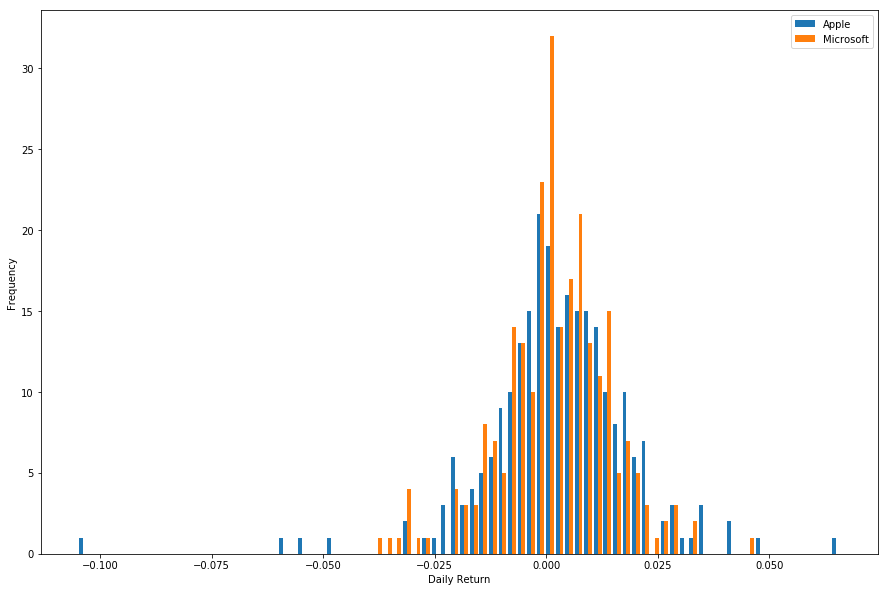

In [7]:
plt.figure(figsize = (15,10))
plt.hist(df_excessRets[['AAPL','MSFT']].values, bins = 80, label = ['Apple', 'Microsoft'])
plt.legend(loc = 0)
plt.xlabel('Daily Return')
plt.ylabel('Frequency')


In [8]:
slope_aapl, intercept, r_value, p_value, std_err = linregress(df_rets['SPY'].dropna(),df_rets['AAPL'].dropna())
print(f"slope: {slope_aapl : .4f},\nintercept: {intercept},\nr_value: {r_value},\np_value: {p_value},\nstd_err: {std_err}")

slope:  1.5588,
intercept: 0.0008495863745590592,
r_value: 0.7426972846572542,
p_value: 2.9084017909246875e-45,
std_err: 0.08906776382981213


In [9]:
beta_aapl = slope_aapl

c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


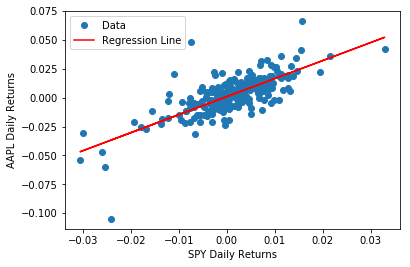

In [10]:
plt.plot(df_rets['SPY'], df_rets['AAPL'],'o', label = 'Data')
plt.plot(df_rets['SPY'], beta_aapl*df_rets['SPY']+intercept, 'r', label = 'Regression Line')
plt.xlabel('SPY Daily Returns')
plt.ylabel('AAPL Daily Returns')
plt.legend()

Otherwise, $\beta$ can be calculated using the following formula:

$
\beta_i = \rho_{im} * \frac{\sigma_i}{\sigma_m}
$

* where $ \rho_{im} $ is the correlation between the stock and the market
* $ \sigma_i $: is the standard deviation (volatility) of the stock
* $ \sigma_m $: is the standard deviation (volatility) of the market

In [11]:
raw_AAPL_SPY = ((df_rets[['AAPL','SPY']]).corr()).iloc[0,1]
std_SPY = df_rets['SPY'].std()
std_AAPL = df_rets['AAPL'].std()
raw_AAPL_SPY*(std_AAPL/std_SPY)

1.5588305072080715

or 

$
\beta_i = \frac{\sigma_i}{{\sigma_m}^2}
$

* $ \sigma_i $: is the standard deviation (volatility) of the stock
* $ \sigma_m $: is the standard deviation (volatility) of the market

In [12]:
cov_AAPL_SPY = ((df_rets[['AAPL','SPY']]).cov()).iloc[0,1]
std_SPY = df_rets['SPY'].std()
cov_AAPL_SPY/(std_SPY**2)

1.5588305072080728

$\beta$ is greater than 1. This means Apple is 55% more volatile than the market and will add risk. It is worth saying that this could mean 55% more profit and 55% more loss! 

Now that we have Apple's $\beta$, let us calculate its actual expected return and plot it against the Security Market Line (SML) to evaluate if it under or overvalued. 
The SML will tell us what Apple's expected return should be given its risk ($\beta$).

$
Annual Return = (1 + Cumulative Return)^{\frac{Yearly Trading Days}{Total Holding Days}} - 1
$

In [13]:
cml_ret = np.exp(np.cumsum(df_rets))-1
total_holding_days = len(df_rets.index)

ann_ret = np.power((1+cml_ret).iloc[-1], (yearlyTradingDays/total_holding_days)) - 1 


In [14]:
print(f"We now have Apple's $\beta$ and it annual return: ({beta_aapl}, {ann_ret['AAPL']}) ")

We now have Apple's eta$ and it annual return: (1.5588305072080737, 0.8874247274410576) 


Let us plot the SML, and see if Apple's (risk, annual return) falls above (undervalued) or below (overvalued) the line. We will use SP500 as our benchmark.
The SML can be drawn using the following formula: 

$
E_{i} = Risk Free Rate + \beta_i * (R_{m} - Risk Free Rate)
$

where $E_{i}$ is the considered stock's expected annual return
and $R_{m}$ is the portfolio's annual return

For the SML: 
* For $\beta = 0$, the Expected return is the Risk Free Rate
* For $\beta = 1$ , the Expected return is the portfolio's annual return 

Text(0, 0.5, 'Expected Return')

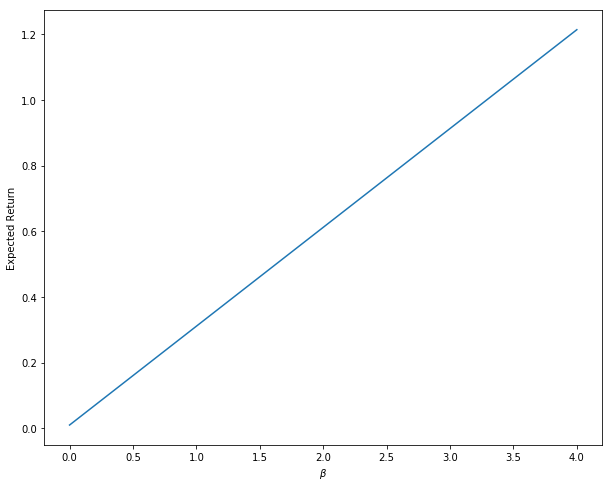

In [15]:

SML_slope = (ann_ret.SPY-yearlyRiskFreeRate)/(1-0) #slope of the SML using SP500 as the market portfolio
ax, fig = plt.subplots(figsize = (10,8))
ax = plt.plot([0, 1,4], [yearlyRiskFreeRate,ann_ret.SPY, 4*SML_slope+yearlyRiskFreeRate]) #SML line
plt.xlabel(r"$\beta$")
plt.ylabel("Expected Return")


In [19]:
expected_ret_aapl = yearlyRiskFreeRate + beta_aapl*(ann_ret.SPY - yearlyRiskFreeRate)
print(f"For apple's \u03B2, the expected return is: {expected_ret_aapl} ")
print(f"However, the actual return is: {ann_ret.AAPL}")


For apple's β, the expected return is: 0.4790127966289961 
However, the actual return is: 0.8874247274410576


We can already conclude that Apple is undervalued. Let's inspect that visually.

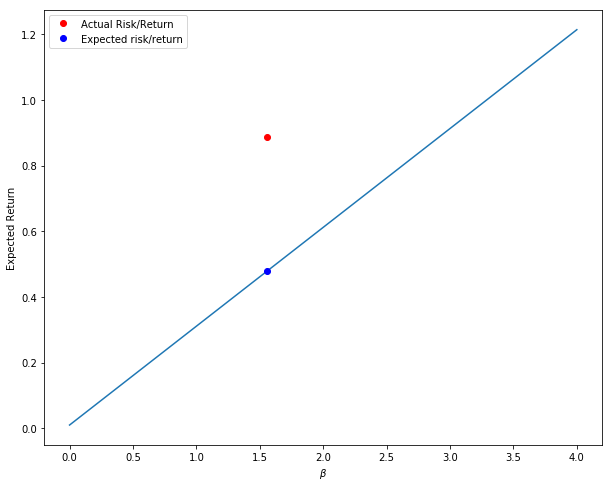

In [40]:
SML_slope = (ann_ret.SPY-yearlyRiskFreeRate)/(1-0) #slope of the SML using SP500 as the market portfolio
ax, fig = plt.subplots(figsize = (10,8))
ax = plt.plot([0, 1,4], [yearlyRiskFreeRate,ann_ret.SPY, 4*SML_slope+yearlyRiskFreeRate]) #SML line
plt.xlabel(r"$\beta$")
plt.ylabel("Expected Return")
ax = plt.plot([beta_aapl],[ann_ret.AAPL],'ro', label = 'Actual Risk/Return')
ax = plt.plot( [slope_aapl],[yearlyRiskFreeRate + slope_aapl*(ann_ret.SPY - yearlyRiskFreeRate)],'bo', label = 'Expected risk/return')
plt.legend()
plt.show()

In [32]:
excess_ret_aapl = ann_ret.AAPL - expected_ret_aapl
print(f'excess return from Apple is {excess_ret_aapl*100:.2f}%')

excess return from Apple is 40.84%


Now, the conclusion here is that Apple isundervalued and should probably be added to our portfolio (S&P500 in this case). 
However, you can see how this analysis is faulty, as Apple is already in the S&P500. 
This was just for illustrative purposes. 
But given that $\beta$ is an estimation of volatility (both good and bad), let us dig a bit more deeper into the statistic.

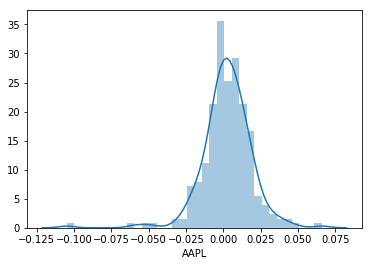

In [20]:
import seaborn as sns
sns.distplot(df_rets['AAPL'].dropna())

In [21]:
print(f"Skewness is {df_rets['AAPL'].dropna().skew()}")
#print(f"Kurtosis {df_rets['AAPL'].dropna().kurt()}")

Skewness is -1.1339500595369638


The skewness tells me the distribution is negatively skewed. However, it does not tell me the total number of negative returns and the total number of positive returns.

How many positive returns do i have?

In [22]:
print(f"Of all returns, {len(df_rets['AAPL'][df_rets['AAPL']<0])/len(df_rets['AAPL'])*100: .2f}% are negative",\
    f"and {len(df_rets['AAPL'][df_rets['AAPL']>=0])/len(df_rets['AAPL'])*100: .2f}% are positive ")


Of all returns,  41.67% are negative and  57.94% are positive 


In [23]:
print(f"The win/loss ratio is {len(df_rets['AAPL'][df_rets['AAPL']>=0])/len(df_rets['AAPL'][df_rets['AAPL']<0]):.2f}")

The win/loss ratio is 1.39


This means for every 14 winning trades, we are losing 10. That is a good Win/Loss Ratio. 

In [24]:
print(f"For winning trades, the average return is {df_rets['AAPL'][df_rets['AAPL']>=0].mean() *100: .2f}%",\
f"and the maximum daily positive return is {df_rets['AAPL'][df_rets['AAPL']>=0].max() *100:.2f}%")

For winning trades, the average return is  1.22% and the maximum daily positive return is 6.61%


In [25]:
print(f"For losing trades, the average return is {df_rets['AAPL'][df_rets['AAPL']<0].mean() *100: .2f}%",\
f"and the maximum daily negative return is {df_rets['AAPL'][df_rets['AAPL']<0].min() *100:.2f}%")

For losing trades, the average return is -1.09% and the maximum daily negative return is -10.49%


So not only is the number of positive returns higher than the losing ones, bu the average return for positive returns is also higher than that of losing returns.

Let's check the data distribution using a boxplot.

{'whiskers': [<matplotlib.lines.Line2D at 0x22df0b09748>,
 'caps': [<matplotlib.lines.Line2D at 0x22df0b09dd8>,
 'boxes': [<matplotlib.lines.Line2D at 0x22df0bf50b8>],
 'medians': [<matplotlib.lines.Line2D at 0x22df0b114a8>],
 'fliers': [<matplotlib.lines.Line2D at 0x22df0b117f0>],
 'means': []}

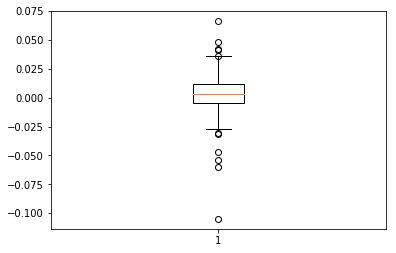

In [26]:
plt.boxplot(df_rets['AAPL'].dropna())

SML showed that Apple is undervalued. In addition:
* It has more positive returns than negative. 
* The average positive return is higher than the negative one
* The big losses seem to be outliers rather than a trend. 

Buying apple seems to be quite obvious